In [2]:
import os
import sys
import datetime as dt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


# monitor start time
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # ignore warning

# Seed
seed_num = 30
np.random.seed(seed_num)
torch.manual_seed(seed_num)

# Hyper Pameters
class_num = 10  # mnist
num_epochs = 30
batch_size = 100
learning_rate = 5e-3
# dtype = torch.cuda.FloatTensor  # run on GPU
dtype = torch.FloatTensor  # run on CPU

transform = transforms.Compose([transforms.ToTensor()])

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/', train=True, transform=transform, download=True)
test_dataset = dsets.MNIST(root='./data/', train=False, transform=transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



def get_weight(shape, zeros=None):
    np.random.seed(seed_num)
    if zeros is None:
        w = np.random.normal(0, 1.0, shape)
        w = torch.from_numpy(w/(np.sqrt(sum(shape)/2.0)))
    else:
        w = np.zeros(shape)
        w = torch.from_numpy(w)
    return Variable(w.type(dtype), requires_grad=True)


def get_bias(shape):
    bias = 0.01 * np.random.rand(shape)
    bias = torch.from_numpy(bias)
    return Variable(bias.type(dtype), requires_grad=True)


def calculate_svd(X):
    U, S_diag, V = torch.linalg.svd(X, full_matrices=False)
    S = torch.diag(S_diag)
    return U, S, V

def incre_svd(A, U_incre, S_incre):

    num_sample  = A.shape[1]
    num_dim = A.shape[0]

    D = torch.matmul(torch.transpose(U_incre, 0, 1), A)

    E = A - torch.matmul(U_incre, D)

    I = torch.eye(num_sample).type(torch.float32)
    zero_matrix1 = torch.zeros(num_dim, num_dim).type(torch.float32)

    # QR for unitary
    E, R_E = torch.qr(E)

    # Form S_W
    top_row = torch.cat([S_incre, D], dim=1)
    bottom_row = torch.cat([zero_matrix1, R_E], dim=1)
    S_W = torch.cat([top_row, bottom_row], dim=0)

    U_S, S_S, V_S = calculate_svd(S_W)

    # update U, S, V
    U_incre = torch.matmul(torch.cat([U_incre, E], dim=1), U_S)

    S_incre = S_S

    print('U_incre, S_incre, V_incre after incremental updating')
    print(U_incre.shape, S_incre.shape)

    # truncation
    U_incre = U_incre[:, :num_dim]
    S_incre = S_incre[:num_dim, :num_dim]
    # V_incre = V_incre[:num_dim]

    print('U_incre, S_incre, V_incre after truncation')
    print(U_incre.shape, S_incre.shape)

    return U_incre, S_incre

num_hidden = 400
# Layer1
w1 = get_weight([28*28, num_hidden])
b1 = get_bias(w1.size(1))
# Layer_out
wo = get_weight([num_hidden, class_num])
myAFun = nn.ReLU().cuda()
# myDrop = nn.Dropout(p=0).cuda()
criterion = nn.CrossEntropyLoss().cuda()
lambda_loss = 1e-3
Task_num = 10

# rank1 = 28*28 -10
# rank2 = 100 -10

rank1 = 250
rank2 = 150

for task_index in range(Task_num):
    ss = np.arange(28*28)
    if task_index > 0:
        np.random.seed(task_index)
        np.random.shuffle(ss)

        U1m = torch.matmul(U1[:, rank1:], U1[:, rank1:].t())
        U2m = torch.matmul(U2[:, rank2:], U2[:, rank2:].t())

    else:
        U1m = Variable(torch.eye(28*28).type(dtype), volatile=True)
        U2m = Variable(torch.eye(num_hidden).type(dtype), volatile=True)

    if task_index > 0:
        num_epochs = 60
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            labels = Variable(labels)
            images = Variable(images)

            images = images.view(-1, 28 * 28)
            numpy_data = images.data.cpu().numpy()
            input = torch.from_numpy(numpy_data[:10000, ss])
            input = Variable(input.type(dtype))

            # Forward + Backward + Optimize
            output1 = myAFun(input.mm(w1))
            y_pred = output1.mm(wo)
            # loss = criterion(y_pred, labels)+lambda_loss*(torch.norm(w1)+torch.norm(wo))
            loss = criterion(y_pred, labels)
            loss.backward()

            # w1 shape: 784 x 100
            # wo shape: 100x 10

            w1.data -= learning_rate * torch.mm(U1m, w1.grad.data)
            w1.grad.data.zero_()

            wo.data -= learning_rate *  torch.mm(U2m, wo.grad.data)
            wo.grad.data.zero_()

            if ((i + 1) % (len(train_dataset) // batch_size)) == 0:
                print('Task [{:d}/{:d}]: Epoch [{:d}/{:d}], Iter [{:d}/{:d}] Loss: {:.3f}'
                      .format(task_index + 1, Task_num, epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size,
                              loss.data))

    print('update U matrices!')

    tmp_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28)
        images = images.data.cpu().numpy()[:50, ss]
        tmp_list.append(images)

    tmp_list = np.array(tmp_list)
    print(tmp_list.shape)
    print('max, min')
    print(np.max(tmp_list), np.min(tmp_list))

    tmp_list = np.reshape(tmp_list, (-1, 28 * 28))
    print(tmp_list.shape)
    input1 = torch.from_numpy(tmp_list)

    input1 = Variable(input1)
    # Forward
    input2 = myAFun(input1.mm(w1))
    print(input2.shape)

    if task_index > 0 and task_index < (Task_num-1):
        print('incre SVD')
        U1, S1 = incre_svd(input1.t(), U1, S1)
        print(U1.shape, S1.shape)

        U2, S2 = incre_svd(input2.t(), U2, S2)
    else:
        print('init SVD')
        U1, S1, V1 = calculate_svd(input1.t())
        U2, S2, V2 = calculate_svd(input2.t())


# Test the Model
correct_all = []
for task_index in range(Task_num):
    ss = np.arange(28 * 28)
    if task_index > 0:
        np.random.seed(task_index)
        np.random.shuffle(ss)
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images)
        images = images.view(-1, 28 * 28)
        numpy_data = images.data.cpu().numpy()
        input = torch.from_numpy(numpy_data[:, ss])
        input = Variable(input.type(dtype))
        # Forward
        output1 = myAFun(input.mm(w1))
        y_pred = output1.mm(wo)

        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    correct_all.append((100 * correct / total))
    print('Test Accuracy of the model on the 10000 Shuffled_mnist images: %0.2f %%' % (100 * correct / total))


print("Average Test Accuracy on All Tasks: {0:.2f} %".format(sum(correct_all) / len(correct_all)))

# monitor end time
end_time = dt.datetime.now()
print('Stop learning {}'.format(str(end_time)))
elapsed_time = end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2025-03-18 20:37:26.200450


<ipython-input-2-a3d87dc5c136>:133: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U1m = Variable(torch.eye(28*28).type(dtype), volatile=True)
<ipython-input-2-a3d87dc5c136>:134: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U2m = Variable(torch.eye(num_hidden).type(dtype), volatile=True)


Task [1/10]: Epoch [1/30], Iter [600/600] Loss: 0.918
Task [1/10]: Epoch [2/30], Iter [600/600] Loss: 0.658
Task [1/10]: Epoch [3/30], Iter [600/600] Loss: 0.404
Task [1/10]: Epoch [4/30], Iter [600/600] Loss: 0.419
Task [1/10]: Epoch [5/30], Iter [600/600] Loss: 0.531
Task [1/10]: Epoch [6/30], Iter [600/600] Loss: 0.204
Task [1/10]: Epoch [7/30], Iter [600/600] Loss: 0.248
Task [1/10]: Epoch [8/30], Iter [600/600] Loss: 0.302
Task [1/10]: Epoch [9/30], Iter [600/600] Loss: 0.330
Task [1/10]: Epoch [10/30], Iter [600/600] Loss: 0.357
Task [1/10]: Epoch [11/30], Iter [600/600] Loss: 0.302
Task [1/10]: Epoch [12/30], Iter [600/600] Loss: 0.382
Task [1/10]: Epoch [13/30], Iter [600/600] Loss: 0.394
Task [1/10]: Epoch [14/30], Iter [600/600] Loss: 0.320
Task [1/10]: Epoch [15/30], Iter [600/600] Loss: 0.280
Task [1/10]: Epoch [16/30], Iter [600/600] Loss: 0.233
Task [1/10]: Epoch [17/30], Iter [600/600] Loss: 0.207
Task [1/10]: Epoch [18/30], Iter [600/600] Loss: 0.193
Task [1/10]: Epoch 

# Clean-up

In [ ]:
import os
import sys
import datetime as dt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

# monitor start time
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # ignore warning

# Seed
seed_num = 30
np.random.seed(seed_num)
torch.manual_seed(seed_num)

# Hyper Pameters
class_num = 10  # mnist
num_epochs = 10
batch_size = 100
learning_rate = 1e-2
# dtype = torch.cuda.FloatTensor  # run on GPU
dtype = torch.FloatTensor  # run on CPU

transform = transforms.Compose([
    transforms.ToTensor()])

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/', train=True, transform=transform, download=True)

test_dataset = dsets.MNIST(root='./data/', train=False, transform=transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



def shuffle_tensor(tensor, axis):
    """Shuffles a tensor along a specified axis."""

    # tensor = tensor.cuda()

    # Get permutation indices
    # perm = torch.randperm(tensor.shape[axis]).cuda()

    perm = torch.randperm(tensor.shape[axis])

    # Permute the tensor
    # tensor = tensor.index_select(axis, perm).cuda()
    tensor = tensor.index_select(axis, perm)

    return tensor


def get_weight(shape, zeros=None):
    np.random.seed(seed_num)
    if zeros is None:
        w = np.random.normal(0, 1.0, shape)
        w = torch.from_numpy(w/(np.sqrt(sum(shape)/2.0)))
    else:
        w = np.zeros(shape)
        w = torch.from_numpy(w)
    return Variable(w.type(dtype), requires_grad=True)


def get_bias(shape):
    bias = 0.01 * np.random.rand(shape)
    bias = torch.from_numpy(bias)
    return Variable(bias.type(dtype), requires_grad=True)


import os
import sys
import datetime as dt
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms


def gram_schmidt_git(vv):
    def projection(u, v):
        return (v * u).sum() / (u * u).sum() * u

    nk = vv.size(0)
    uu = torch.zeros_like(vv, device=vv.device)
    uu[:, 0] = vv[:, 0].clone()
    for k in range(1, nk):
        vk = vv[k].clone()
        uk = 0
        for j in range(0, k):
            uj = uu[:, j].clone()
            uk = uk + projection(uj, vk)
        uu[:, k] = vk - uk
    for k in range(nk):
        uk = uu[:, k].clone()
        uu[:, k] = uk / uk.norm()
    return uu


def calculate_svd(X):
    U, S_diag, V = torch.linalg.svd(X, full_matrices=False)
    S = torch.diag(S_diag)
    return U, S, V



def incre_svd(A, U_incre, S_incre):

    num_sample  = A.shape[1]
    num_dim = A.shape[0]

    D = torch.matmul(torch.transpose(U_incre, 0, 1), A)

    E = A - torch.matmul(U_incre, D)

    I = torch.eye(num_sample).type(torch.float32)
    zero_matrix1 = torch.zeros(num_dim, num_dim).type(torch.float32)

    # QR for unitary
    E, R_E = torch.qr(E)

    # Form S_W
    top_row = torch.cat([S_incre, D], dim=1)
    bottom_row = torch.cat([zero_matrix1, R_E], dim=1)
    S_W = torch.cat([top_row, bottom_row], dim=0)

    U_S, S_S, V_S = calculate_svd(S_W)

    # update U, S, V
    U_incre = torch.matmul(torch.cat([U_incre, E], dim=1), U_S)

    S_incre = S_S

    print('U_incre, S_incre, V_incre after incremental updating')
    print(U_incre.shape, S_incre.shape)

    # truncation
    U_incre = U_incre[:, :num_dim]
    S_incre = S_incre[:num_dim, :num_dim]
    # V_incre = V_incre[:num_dim]

    print('U_incre, S_incre, V_incre after truncation')
    print(U_incre.shape, S_incre.shape)

    return U_incre, S_incre

# Layer1
w1 = get_weight([28*28, 100])
b1 = get_bias(w1.size(1))
# Layer_out
wo = get_weight([100, class_num])
myAFun = nn.ReLU().cuda()
# myDrop = nn.Dropout(p=0).cuda()
criterion = nn.CrossEntropyLoss().cuda()
lambda_loss = 1e-3
Task_num = 2

for task_index in range(Task_num):
    ss = np.arange(28*28)
    if task_index > 0:
        np.random.seed(task_index)
        np.random.shuffle(ss)

        print('after trim:', U1.shape, U2.shape)

    else:
        U1 = Variable(torch.eye(28*28).type(dtype), volatile=True)
        U2 = Variable(torch.eye(100).type(dtype), volatile=True)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            labels = Variable(labels)
            images = Variable(images)

            images = images.view(-1, 28 * 28)
            numpy_data = images.data.cpu().numpy()
            input = torch.from_numpy(numpy_data[:10000, ss])
            input = Variable(input.type(dtype))

            # Forward + Backward + Optimize
            output1 = myAFun(input.mm(w1))

            y_pred = output1.mm(wo)
            # loss = criterion(y_pred, labels)+lambda_loss*(torch.norm(w1)+torch.norm(wo))
            loss = criterion(y_pred, labels)
            loss.backward()

            # print(w1.grad.data.shape)
            # w1 shape: 784 x 100

            # print(wo.grad.data.shape)
            # wo shape: 100x 10

            w1.data -= learning_rate * torch.mm(U1, w1.grad.data)
            w1.grad.data.zero_()

            wo.data -= learning_rate *  torch.mm(U2, wo.grad.data)
            wo.grad.data.zero_()

            if ((i + 1) % (len(train_dataset) // batch_size)) == 0:
                print('Task [{:d}/{:d}]: Epoch [{:d}/{:d}], Iter [{:d}/{:d}] Loss: {:.3f}'
                      .format(task_index + 1, Task_num, epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size,
                              loss.data))

    print('update U matrices!')

    tmp_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        images = images.view(-1, 28 * 28)
        images = images.data.cpu().numpy()[:10, ss]
        tmp_list.append(images)

    tmp_list = np.array(tmp_list)
    print(tmp_list.shape)
    print('MNIST max, min')
    print(np.max(tmp_list), np.min(tmp_list))

    tmp_list = np.reshape(tmp_list, (-1, 28 * 28))
    input1 = torch.from_numpy(tmp_list)

    input1 = Variable(input1)

    # Forward
    input2 = myAFun(input1.mm(w1))

    print('input1, input2')
    print(input1.shape)
    print(input2.shape)

    if task_index > 0 and task_index < (Task_num-1):
        print('incre SVD')
        print(task_index)
    else:
        print('init SVD')
        U1, S1, V1 = calculate_svd(input1.t())
        print(U1.shape, S1.shape, V1.shape)

        rank1 = 28*28 -10

        zero_matrix1 = torch.zeros(rank1, 28*28).type(torch.float32)
        U1 = torch.cat([U1[rank1:], zero_matrix1], dim=0)

        # zero_matrix1 = torch.zeros(28*28, rank1).type(torch.float32)
        # U1 = torch.cat([U1[:, rank1:], zero_matrix1], dim=1)

        # ones_matrix1 = torch.eye(28*28).type(torch.float32)
        # ones_matrix1[:, rank1:] = U1[:, rank1:]
        # U1 = ones_matrix1
        print('max min after cat')

        print(torch.max(U1))
        print(torch.min(U1))

        U2, S2, V2 = calculate_svd(input2.t())

        rank2 = 100 -10
        zero_matrix2 = torch.zeros(rank2, 100).type(torch.float32)
        U2 = torch.cat([U2[rank2:], zero_matrix2], dim=0)

        # zero_matrix2 = torch.zeros(100, rank2).type(torch.float32)
        # U2 = torch.cat([U2[:, rank2:], zero_matrix2], dim=1)

        # ones_matrix2 = torch.eye(100).type(torch.float32)
        # ones_matrix2[:, rank2:] = U2[:, rank2:]
        # U2 = ones_matrix2

        print('max min after cat')

        print(torch.max(U2))
        print(torch.min(U2))


# Test the Model
correct_all = []
for task_index in range(Task_num):
    ss = np.arange(28 * 28)
    if task_index > 0:
        np.random.seed(task_index)
        np.random.shuffle(ss)
    correct = 0
    total = 0
    for images, labels in test_loader:
        # images = Variable(images).cuda()

        images = Variable(images)

        images = images.view(-1, 28 * 28)
        numpy_data = images.data.cpu().numpy()
        input = torch.from_numpy(numpy_data[:, ss])
        input = Variable(input.type(dtype))
        # Forward
        # output1 = myAFun(input.mm(w1) + b1)
        output1 = myAFun(input.mm(w1))

        y_pred = output1.mm(wo)

        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    correct_all.append((100 * correct / total))
    print('Test Accuracy of the model on the 10000 Shuffled_mnist images: %0.2f %%' % (100 * correct / total))


print("Average Test Accuracy on All Tasks: {0:.2f} %".format(sum(correct_all) / len(correct_all)))

# monitor end time
end_time = dt.datetime.now()
print('Stop learning {}'.format(str(end_time)))
elapsed_time = end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2025-03-12 22:57:19.522399


<ipython-input-6-ccf0d99ba45d>:134: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U1 = Variable(torch.eye(28*28).type(dtype), volatile=True)
<ipython-input-6-ccf0d99ba45d>:135: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U2 = Variable(torch.eye(100).type(dtype), volatile=True)


Task [1/2]: Epoch [1/10], Iter [600/600] Loss: 0.738
Task [1/2]: Epoch [2/10], Iter [600/600] Loss: 0.591
Task [1/2]: Epoch [3/10], Iter [600/600] Loss: 0.318
Task [1/2]: Epoch [4/10], Iter [600/600] Loss: 0.342
Task [1/2]: Epoch [5/10], Iter [600/600] Loss: 0.480
Task [1/2]: Epoch [6/10], Iter [600/600] Loss: 0.132
Task [1/2]: Epoch [7/10], Iter [600/600] Loss: 0.213
Task [1/2]: Epoch [8/10], Iter [600/600] Loss: 0.253
Task [1/2]: Epoch [9/10], Iter [600/600] Loss: 0.295
Task [1/2]: Epoch [10/10], Iter [600/600] Loss: 0.330
update U matrices!
(600, 10, 784)
MNIST max, min
1.0 0.0
input1, input2
torch.Size([6000, 784])
torch.Size([6000, 100])
init SVD
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 6000])
max min after cat
tensor(1.)
tensor(-0.6292)
max min after cat
tensor(0.3524, grad_fn=<MaxBackward1>)
tensor(-0.7112, grad_fn=<MinBackward1>)
after trim: torch.Size([784, 784]) torch.Size([100, 100])
Task [2/2]: Epoch [1/10], Iter [600/600] Loss: 2.832
Task [2/2]: Epoch

# Main

In [ ]:
import os
import sys
import datetime as dt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

# monitor start time
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # ignore warning

# Seed
seed_num = 30
np.random.seed(seed_num)
torch.manual_seed(seed_num)

# Hyper Pameters
class_num = 10  # mnist
num_epochs = 10
batch_size = 100
learning_rate = 1e-2
# dtype = torch.cuda.FloatTensor  # run on GPU
dtype = torch.FloatTensor  # run on CPU

transform = transforms.Compose([
    transforms.ToTensor()])

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/', train=True, transform=transform, download=True)

test_dataset = dsets.MNIST(root='./data/', train=False, transform=transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



def shuffle_tensor(tensor, axis):
    """Shuffles a tensor along a specified axis."""

    # tensor = tensor.cuda()

    # Get permutation indices
    # perm = torch.randperm(tensor.shape[axis]).cuda()

    perm = torch.randperm(tensor.shape[axis])

    # Permute the tensor
    # tensor = tensor.index_select(axis, perm).cuda()
    tensor = tensor.index_select(axis, perm)

    return tensor


def get_weight(shape, zeros=None):
    np.random.seed(seed_num)
    if zeros is None:
        w = np.random.normal(0, 1.0, shape)
        w = torch.from_numpy(w/(np.sqrt(sum(shape)/2.0)))
    else:
        w = np.zeros(shape)
        w = torch.from_numpy(w)
    return Variable(w.type(dtype), requires_grad=True)


def get_bias(shape):
    bias = 0.01 * np.random.rand(shape)
    bias = torch.from_numpy(bias)
    return Variable(bias.type(dtype), requires_grad=True)


import os
import sys
import datetime as dt
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms


def gram_schmidt_git(vv):
    def projection(u, v):
        return (v * u).sum() / (u * u).sum() * u

    nk = vv.size(0)
    uu = torch.zeros_like(vv, device=vv.device)
    uu[:, 0] = vv[:, 0].clone()
    for k in range(1, nk):
        vk = vv[k].clone()
        uk = 0
        for j in range(0, k):
            uj = uu[:, j].clone()
            uk = uk + projection(uj, vk)
        uu[:, k] = vk - uk
    for k in range(nk):
        uk = uu[:, k].clone()
        uu[:, k] = uk / uk.norm()
    return uu


def calculate_svd(X):
    U, S_diag, V = torch.linalg.svd(X, full_matrices=False)
    S = torch.diag(S_diag)
    return U, S, V


def rmse(y_pred, y_true):
    mse = torch.nn.MSELoss()(y_pred, y_true)
    return torch.sqrt(mse)

def incre_svd(A, U_incre, S_incre):

    num_sample  = A.shape[1]
    num_dim = A.shape[0]

    D = torch.matmul(torch.transpose(U_incre, 0, 1), A)

    E = A - torch.matmul(U_incre, D)

    I = torch.eye(num_sample).type(torch.float32)
    zero_matrix1 = torch.zeros(num_dim, num_dim).type(torch.float32)

    # QR for unitary
    E, R_E = torch.qr(E)

    # Form S_W
    top_row = torch.cat([S_incre, D], dim=1)
    bottom_row = torch.cat([zero_matrix1, R_E], dim=1)
    S_W = torch.cat([top_row, bottom_row], dim=0)

    U_S, S_S, V_S = calculate_svd(S_W)

    # update U, S, V
    U_incre = torch.matmul(torch.cat([U_incre, E], dim=1), U_S)

    S_incre = S_S

    print('U_incre, S_incre, V_incre after incremental updating')
    print(U_incre.shape, S_incre.shape)

    # truncation
    U_incre = U_incre[:, :num_dim]
    S_incre = S_incre[:num_dim, :num_dim]
    # V_incre = V_incre[:num_dim]

    print('U_incre, S_incre, V_incre after truncation')
    print(U_incre.shape, S_incre.shape)

    return U_incre, S_incre


# def zero_pad_u(U, rank_r):


alpha = 1.0
# Layer1
w1 = get_weight([28*28, 100])
b1 = get_bias(w1.size(1))
# Layer_out
wo = get_weight([100, class_num])
myAFun = nn.ReLU().cuda()
# myDrop = nn.Dropout(p=0).cuda()
criterion = nn.CrossEntropyLoss().cuda()
lambda_loss = 1e-3
Task_num = 2

for task_index in range(Task_num):
    ss = np.arange(28*28)
    if task_index > 0:
        np.random.seed(task_index)
        np.random.shuffle(ss)

        print('after trim:', U1.shape, U2.shape)

    else:
        U1 = Variable(torch.eye(28*28).type(dtype), volatile=True)
        U2 = Variable(torch.eye(100).type(dtype), volatile=True)
        # logging.info('norm :', torch.norm(U1), torch.norm(U2))

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # labels = Variable(labels).cuda()
            # images = Variable(images).cuda()
            labels = Variable(labels)
            images = Variable(images)

            images = images.view(-1, 28 * 28)
            numpy_data = images.data.cpu().numpy()
            input = torch.from_numpy(numpy_data[:10000, ss])
            input = Variable(input.type(dtype))
            # Forward + Backward + Optimize
            # output1 = myAFun(input.mm(w1) + b1)
            output1 = myAFun(input.mm(w1))

            y_pred = output1.mm(wo)
            loss = criterion(y_pred, labels)+lambda_loss*(torch.norm(w1)+torch.norm(wo))
            loss.backward()

            # print(w1.grad.data.shape)
            # w1 shape: 784 x 100

            # print(wo.grad.data.shape)
            # wo shape: 100x 10

            w1.data -= learning_rate * torch.mm(U1, w1.grad.data)
            w1.grad.data.zero_()

            wo.data -= learning_rate *  torch.mm(U2, wo.grad.data)
            wo.grad.data.zero_()

            if ((i + 1) % (len(train_dataset) // batch_size)) == 0:
                print('Task [{:d}/{:d}]: Epoch [{:d}/{:d}], Iter [{:d}/{:d}] Loss: {:.3f}'
                      .format(task_index + 1, Task_num, epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size,
                              loss.data))

    print('update U matrices!')

    tmp_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28)
        images = images.data.cpu().numpy()[:10, ss]
        tmp_list.append(images)

    tmp_list = np.array(tmp_list)
    print(tmp_list.shape)
    print('max, min')
    print(np.max(tmp_list), np.min(tmp_list))

    tmp_list = np.reshape(tmp_list, (-1, 28 * 28))
    print(tmp_list.shape)
    input1 = torch.from_numpy(tmp_list)

    # input = Variable(input).cuda()
    input = Variable(input1)
    # Forward
    # input2 = myAFun(input.mm(w1) + b1)
    input2 = myAFun(input.mm(w1))
    print(input2.shape)

    if task_index > 0 and task_index < (Task_num-1):
        print('incre SVD')
        print(input1.shape)
        print(input2.shape)

        U1, S1 = incre_svd(input1.t(), U1, S1)
        print(U1.shape, S1.shape)

        U2, S2 = incre_svd(input2.t(), U2, S2)
        print(U2.shape, S2.shape)

        # rank1 = torch.linalg.matrix_rank(U1)
        rank1 = 28*28
        print('rank1')
        print(rank1)

        # zero_matrix1 = torch.zeros(rank1, 28*28).type(torch.float32)
        # U1 = torch.cat([U1[rank1:], zero_matrix1], dim=0)

        zero_matrix1 = torch.zeros(28*28, rank1).type(torch.float32)
        U1 = torch.cat([U1[:, rank1:], zero_matrix1], dim=1)

        print(torch.max(U1))
        print(torch.min(U1))

        # ones_matrix1 = torch.eye(28*28).type(torch.float32)
        # ones_matrix1[:, rank1:] = U1[:, rank1:]
        # U1 = ones_matrix1

        U2, S2, V2 = calculate_svd(input2.t())
        U2 = gram_schmidt_git(U2)
        print(U2.shape, S2.shape, V2.shape)

        # rank2 = torch.linalg.matrix_rank(U2)
        rank2 = 100
        print('rank2')
        print(rank2)
        # zero_matrix2 = torch.zeros(rank2, 100).type(torch.float32)
        # U2 = torch.cat([U2[rank2:], zero_matrix2], dim=0)

        # zero_matrix2 = torch.zeros(100, rank2).type(torch.float32)
        # U2 = torch.cat([U2[:, rank2:], zero_matrix2], dim=1)

        ones_matrix2 = torch.eye(100).type(torch.float32)
        # U2 = torch.cat([U2[:, rank2:], zero_matrix2], dim=1)
        ones_matrix2[:, rank2:] = U2[:, rank2:]
        U2 = ones_matrix2

        print(torch.max(U2))
        print(torch.min(U2))

    else:
        print('init SVD')
        U1, S1, V1 = calculate_svd(input1.t())
        print(U1.shape, S1.shape, V1.shape)

        print('max min before GS')
        print(torch.max(U1))
        print(torch.min(U1))

        # U1 = gram_schmidt_git(U1)

        print('max min after GS')
        print(torch.max(U1))
        print(torch.min(U1))

        rank1 = 28*28 -10
        # print('rank1')
        # print(rank1)

        zero_matrix1 = torch.zeros(rank1, 28*28).type(torch.float32)
        U1 = torch.cat([U1[rank1:], zero_matrix1], dim=0)

        # zero_matrix1 = torch.zeros(28*28, rank1).type(torch.float32)
        # U1 = torch.cat([U1[:, rank1:], zero_matrix1], dim=1)

        print('max min after cat')

        print(torch.max(U1))
        print(torch.min(U1))

        # ones_matrix1 = torch.eye(28*28).type(torch.float32)
        # ones_matrix1[:, rank1:] = U1[:, rank1:]
        # U1 = ones_matrix1

        U2, S2, V2 = calculate_svd(input2.t())

        print('max min before GS')
        print(torch.max(U2))
        print(torch.min(U2))

        # U2 = gram_schmidt_git(U2)

        print('max min after GS')
        print(torch.max(U2))
        print(torch.min(U2))
        # print(U2.shape, S2.shape, V2.shape)

        # rank2 = torch.linalg.matrix_rank(U2)
        rank2 = 100 -10
        print('rank2')
        print(rank2)
        zero_matrix2 = torch.zeros(rank2, 100).type(torch.float32)
        U2 = torch.cat([U2[rank2:], zero_matrix2], dim=0)

        # zero_matrix2 = torch.zeros(100, rank2).type(torch.float32)
        # U2 = torch.cat([U2[:, rank2:], zero_matrix2], dim=1)

        # ones_matrix2 = torch.eye(100).type(torch.float32)
        # # U2 = torch.cat([U2[:, rank2:], zero_matrix2], dim=1)
        # ones_matrix2[:, rank2:] = U2[:, rank2:]
        # U2 = ones_matrix2

        print('max min after cat')

        print(torch.max(U2))
        print(torch.min(U2))



    # U1 = Variable(torch.eye(28*28).type(dtype), volatile=True)
    # U2 = Variable(torch.eye(100).type(dtype), volatile=True)



# Test the Model
correct_all = []
for task_index in range(Task_num):
    ss = np.arange(28 * 28)
    if task_index > 0:
        np.random.seed(task_index)
        np.random.shuffle(ss)
    correct = 0
    total = 0
    for images, labels in test_loader:
        # images = Variable(images).cuda()

        images = Variable(images)

        images = images.view(-1, 28 * 28)
        numpy_data = images.data.cpu().numpy()
        input = torch.from_numpy(numpy_data[:, ss])
        input = Variable(input.type(dtype))
        # Forward
        # output1 = myAFun(input.mm(w1) + b1)
        output1 = myAFun(input.mm(w1))

        y_pred = output1.mm(wo)

        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    correct_all.append((100 * correct / total))
    print('Test Accuracy of the model on the 10000 Shuffled_mnist images: %0.2f %%' % (100 * correct / total))


print("Average Test Accuracy on All Tasks: {0:.2f} %".format(sum(correct_all) / len(correct_all)))

# monitor end time
end_time = dt.datetime.now()
print('Stop learning {}'.format(str(end_time)))
elapsed_time = end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2025-03-12 19:34:01.929994
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 613kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.67MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.97MB/s]
<ipython-input-1-2014fc4f92eb>:183: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U1 = Variable(torch.eye(28*28).type(dtype), volatile=True)
<ipython-input-1-2014fc4f92eb>:184: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U2 = Variable(torch.eye(100).type(dtype), volatile=True)


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Task [1/2]: Epoch [1/10], Iter [600/600] Loss: 0.757
Task [1/2]: Epoch [2/10], Iter [600/600] Loss: 0.610
Task [1/2]: Epoch [3/10], Iter [600/600] Loss: 0.338
Task [1/2]: Epoch [4/10], Iter [600/600] Loss: 0.362
Task [1/2]: Epoch [5/10], Iter [600/600] Loss: 0.500
Task [1/2]: Epoch [6/10], Iter [600/600] Loss: 0.153
Task [1/2]: Epoch [7/10], Iter [600/600] Loss: 0.233
Task [1/2]: Epoch [8/10], Iter [600/600] Loss: 0.274
Task [1/2]: Epoch [9/10], Iter [600/600] Loss: 0.316
Task [1/2]: Epoch [10/10], Iter [600/600] Loss: 0.351
update U matrices!
(600, 10, 784)
max, min
1.0 0.0
(6000, 784)
torch.Size([6000, 100])
init SVD
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 6000])
max min before GS
tensor(1.)
tensor(-1.)
max min after GS
tensor(1.)
tensor(-1.)
max min after cat
tensor(1.)
tensor(-0.6292)
max min before GS
tensor(0.9994, grad_fn=<MaxBackward1>)
tensor(-0.8888, grad_fn=<MinBackward1>)
max m

Start learning at 2025-03-12 01:23:01.974385
<ipython-input-12-2c664ed04713>:183: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U1 = Variable(torch.eye(28*28).type(dtype), volatile=True)
<ipython-input-12-2c664ed04713>:184: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U2 = Variable(torch.eye(100).type(dtype), volatile=True)
Task [1/2]: Epoch [1/10], Iter [600/600] Loss: 0.757
Task [1/2]: Epoch [2/10], Iter [600/600] Loss: 0.610
Task [1/2]: Epoch [3/10], Iter [600/600] Loss: 0.338
Task [1/2]: Epoch [4/10], Iter [600/600] Loss: 0.362
Task [1/2]: Epoch [5/10], Iter [600/600] Loss: 0.500
Task [1/2]: Epoch [6/10], Iter [600/600] Loss: 0.153
Task [1/2]: Epoch [7/10], Iter [600/600] Loss: 0.233
Task [1/2]: Epoch [8/10], Iter [600/600] Loss: 0.274
Task [1/2]: Epoch [9/10], Iter [600/600] Loss: 0.316
Task [1/2]: Epoch [10/10], Iter [600/600] Loss: 0.351
update U matrices!
(600, 10, 784)
max, min
1.0 0.0
(6000, 784)
torch.Size([6000, 100])
init SVD
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 6000])
rank1
783
tensor(0.)
tensor(0.)
torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 6000])
rank2
99
tensor(0.3502, grad_fn=<MaxBackward1>)
tensor(-0.2616, grad_fn=<MinBackward1>)
after trim: torch.Size([784, 784]) torch.Size([100, 100])
Task [2/2]: Epoch [1/10], Iter [600/600] Loss: 3.035
Task [2/2]: Epoch [2/10], Iter [600/600] Loss: 3.398
Task [2/2]: Epoch [3/10], Iter [600/600] Loss: 3.293
Task [2/2]: Epoch [4/10], Iter [600/600] Loss: 3.169
Task [2/2]: Epoch [5/10], Iter [600/600] Loss: 3.154
Task [2/2]: Epoch [6/10], Iter [600/600] Loss: 3.416
Task [2/2]: Epoch [7/10], Iter [600/600] Loss: 3.409
Task [2/2]: Epoch [8/10], Iter [600/600] Loss: 3.490
Task [2/2]: Epoch [9/10], Iter [600/600] Loss: 3.116
Task [2/2]: Epoch [10/10], Iter [600/600] Loss: 3.278
update U matrices!
(600, 10, 784)
max, min
1.0 0.0
(6000, 784)
torch.Size([6000, 100])
init SVD
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 6000])
rank1
783
tensor(0.)
tensor(-6.3441e-20)
torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 6000])
rank2
99
tensor(0.2502, grad_fn=<MaxBackward1>)
tensor(-0.2703, grad_fn=<MinBackward1>)
Test Accuracy of the model on the 10000 Shuffled_mnist images: 87.55 %
Test Accuracy of the model on the 10000 Shuffled_mnist images: 10.33 %
Average Test Accuracy on All Tasks: 48.94 %
Stop learning 2025-03-12 01:26:38.063696
Elapsed learning 0:03:36.089311

In [ ]:
import os
import sys
import datetime as dt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

# monitor start time
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # ignore warning

# Seed
seed_num = 30
np.random.seed(seed_num)
torch.manual_seed(seed_num)

# Hyper Pameters
class_num = 10  # mnist
num_epochs = 10
batch_size = 100
learning_rate = 1e-2
# dtype = torch.cuda.FloatTensor  # run on GPU
dtype = torch.FloatTensor  # run on CPU

transform = transforms.Compose([
    transforms.ToTensor()])

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/', train=True, transform=transform, download=True)

test_dataset = dsets.MNIST(root='./data/', train=False, transform=transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



def shuffle_tensor(tensor, axis):
    """Shuffles a tensor along a specified axis."""

    # tensor = tensor.cuda()

    # Get permutation indices
    # perm = torch.randperm(tensor.shape[axis]).cuda()

    perm = torch.randperm(tensor.shape[axis])

    # Permute the tensor
    # tensor = tensor.index_select(axis, perm).cuda()
    tensor = tensor.index_select(axis, perm)

    return tensor


def get_weight(shape, zeros=None):
    np.random.seed(seed_num)
    if zeros is None:
        w = np.random.normal(0, 1.0, shape)
        w = torch.from_numpy(w/(np.sqrt(sum(shape)/2.0)))
    else:
        w = np.zeros(shape)
        w = torch.from_numpy(w)
    return Variable(w.type(dtype), requires_grad=True)


def get_bias(shape):
    bias = 0.01 * np.random.rand(shape)
    bias = torch.from_numpy(bias)
    return Variable(bias.type(dtype), requires_grad=True)


import os
import sys
import datetime as dt
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms


def gram_schmidt_git(vv):
    def projection(u, v):
        return (v * u).sum() / (u * u).sum() * u

    nk = vv.size(0)
    uu = torch.zeros_like(vv, device=vv.device)
    uu[:, 0] = vv[:, 0].clone()
    for k in range(1, nk):
        vk = vv[k].clone()
        uk = 0
        for j in range(0, k):
            uj = uu[:, j].clone()
            uk = uk + projection(uj, vk)
        uu[:, k] = vk - uk
    for k in range(nk):
        uk = uu[:, k].clone()
        uu[:, k] = uk / uk.norm()
    return uu


def calculate_svd(X):
    U, S_diag, V = torch.linalg.svd(X, full_matrices=False)
    S = torch.diag(S_diag)
    return U, S, V


def rmse(y_pred, y_true):
    mse = torch.nn.MSELoss()(y_pred, y_true)
    return torch.sqrt(mse)

def incre_svd(A, U_incre, S_incre):

    num_sample  = A.shape[1]
    num_dim = A.shape[0]

    D = torch.matmul(torch.transpose(U_incre, 0, 1), A)

    E = A - torch.matmul(U_incre, D)

    I = torch.eye(num_sample).type(torch.float32)
    zero_matrix1 = torch.zeros(num_dim, num_dim).type(torch.float32)

    # QR for unitary
    E, R_E = torch.qr(E)

    # Form S_W
    top_row = torch.cat([S_incre, D], dim=1)
    bottom_row = torch.cat([zero_matrix1, R_E], dim=1)
    S_W = torch.cat([top_row, bottom_row], dim=0)

    U_S, S_S, V_S = calculate_svd(S_W)

    # update U, S, V
    U_incre = torch.matmul(torch.cat([U_incre, E], dim=1), U_S)

    S_incre = S_S

    print('U_incre, S_incre, V_incre after incremental updating')
    print(U_incre.shape, S_incre.shape)

    # truncation
    U_incre = U_incre[:, :num_dim]
    S_incre = S_incre[:num_dim, :num_dim]
    # V_incre = V_incre[:num_dim]

    print('U_incre, S_incre, V_incre after truncation')
    print(U_incre.shape, S_incre.shape)

    return U_incre, S_incre


# def zero_pad_u(U, rank_r):


alpha = 1.0
# Layer1
w1 = get_weight([28*28, 100])
b1 = get_bias(w1.size(1))
# Layer_out
wo = get_weight([100, class_num])
myAFun = nn.ReLU().cuda()
# myDrop = nn.Dropout(p=0).cuda()
criterion = nn.CrossEntropyLoss().cuda()
lambda_loss = 1e-3
Task_num = 2

for task_index in range(Task_num):
    ss = np.arange(28*28)
    if task_index > 0:
        np.random.seed(task_index)
        np.random.shuffle(ss)

        print('after trim:', U1.shape, U2.shape)

    else:
        U1 = Variable(torch.eye(28*28).type(dtype), volatile=True)
        U2 = Variable(torch.eye(100).type(dtype), volatile=True)
        # logging.info('norm :', torch.norm(U1), torch.norm(U2))

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # labels = Variable(labels).cuda()
            # images = Variable(images).cuda()
            labels = Variable(labels)
            images = Variable(images)

            images = images.view(-1, 28 * 28)
            numpy_data = images.data.cpu().numpy()
            input = torch.from_numpy(numpy_data[:10000, ss])
            input = Variable(input.type(dtype))
            # Forward + Backward + Optimize
            # output1 = myAFun(input.mm(w1) + b1)
            output1 = myAFun(input.mm(w1))

            y_pred = output1.mm(wo)
            loss = criterion(y_pred, labels)+lambda_loss*(torch.norm(w1)+torch.norm(wo))
            loss.backward()

            # print(w1.grad.data.shape)
            # w1 shape: 784 x 100

            # print(wo.grad.data.shape)
            # wo shape: 100x 10

            w1.data -= learning_rate * torch.mm(U1, w1.grad.data)
            w1.grad.data.zero_()

            wo.data -= learning_rate *  torch.mm(U2, wo.grad.data)
            wo.grad.data.zero_()

            if ((i + 1) % (len(train_dataset) // batch_size)) == 0:
                print('Task [{:d}/{:d}]: Epoch [{:d}/{:d}], Iter [{:d}/{:d}] Loss: {:.3f}'
                      .format(task_index + 1, Task_num, epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size,
                              loss.data))

    print('update U matrices!')

    tmp_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28)
        images = images.data.cpu().numpy()[:10, ss]
        tmp_list.append(images)

    tmp_list = np.array(tmp_list)
    print(tmp_list.shape)
    print('max, min')
    print(np.max(tmp_list), np.min(tmp_list))

    tmp_list = np.reshape(tmp_list, (-1, 28 * 28))
    print(tmp_list.shape)
    input1 = torch.from_numpy(tmp_list)

    # input = Variable(input).cuda()
    input = Variable(input1)
    # Forward
    # input2 = myAFun(input.mm(w1) + b1)
    input2 = myAFun(input.mm(w1))
    print(input2.shape)

    if task_index > 0 and task_index < (Task_num-1):
        print('incre SVD')
        print(input1.shape)
        print(input2.shape)

        U1, S1 = incre_svd(input1.t(), U1, S1)
        print(U1.shape, S1.shape)

        U2, S2 = incre_svd(input2.t(), U2, S2)
        print(U2.shape, S2.shape)

        # rank1 = torch.linalg.matrix_rank(U1)
        rank1 = 28*28
        print('rank1')
        print(rank1)

        # zero_matrix1 = torch.zeros(rank1, 28*28).type(torch.float32)
        # U1 = torch.cat([U1[rank1:], zero_matrix1], dim=0)

        zero_matrix1 = torch.zeros(28*28, rank1).type(torch.float32)
        U1 = torch.cat([U1[:, rank1:], zero_matrix1], dim=1)

        print(torch.max(U1))
        print(torch.min(U1))

        # ones_matrix1 = torch.eye(28*28).type(torch.float32)
        # ones_matrix1[:, rank1:] = U1[:, rank1:]
        # U1 = ones_matrix1

        U2, S2, V2 = calculate_svd(input2.t())
        U2 = gram_schmidt_git(U2)
        print(U2.shape, S2.shape, V2.shape)

        # rank2 = torch.linalg.matrix_rank(U2)
        rank2 = 100
        print('rank2')
        print(rank2)
        # zero_matrix2 = torch.zeros(rank2, 100).type(torch.float32)
        # U2 = torch.cat([U2[rank2:], zero_matrix2], dim=0)

        # zero_matrix2 = torch.zeros(100, rank2).type(torch.float32)
        # U2 = torch.cat([U2[:, rank2:], zero_matrix2], dim=1)

        ones_matrix2 = torch.eye(100).type(torch.float32)
        # U2 = torch.cat([U2[:, rank2:], zero_matrix2], dim=1)
        ones_matrix2[:, rank2:] = U2[:, rank2:]
        U2 = ones_matrix2

        print(torch.max(U2))
        print(torch.min(U2))

    else:
        print('init SVD')
        U1, S1, V1 = calculate_svd(input1.t())
        print(U1.shape, S1.shape, V1.shape)

        print('max min before GS')
        print(torch.max(U1))
        print(torch.min(U1))

        # U1 = gram_schmidt_git(U1)

        print('max min after GS')
        print(torch.max(U1))
        print(torch.min(U1))

        rank1 = 28*28 -10
        # print('rank1')
        # print(rank1)

        # zero_matrix1 = torch.zeros(rank1, 28*28).type(torch.float32)
        # U1 = torch.cat([U1[rank1:], zero_matrix1], dim=0)

        zero_matrix1 = torch.zeros(28*28, rank1).type(torch.float32)
        U1 = torch.cat([U1[:, rank1:], zero_matrix1], dim=1)

        print('max min after cat')

        print(torch.max(U1))
        print(torch.min(U1))

        # ones_matrix1 = torch.eye(28*28).type(torch.float32)
        # ones_matrix1[:, rank1:] = U1[:, rank1:]
        # U1 = ones_matrix1

        U2, S2, V2 = calculate_svd(input2.t())

        print('max min before GS')
        print(torch.max(U2))
        print(torch.min(U2))

        # U2 = gram_schmidt_git(U2)

        print('max min after GS')
        print(torch.max(U2))
        print(torch.min(U2))
        # print(U2.shape, S2.shape, V2.shape)

        # rank2 = torch.linalg.matrix_rank(U2)
        rank2 = 100 -10
        print('rank2')
        print(rank2)
        # zero_matrix2 = torch.zeros(rank2, 100).type(torch.float32)
        # U2 = torch.cat([U2[rank2:], zero_matrix2], dim=0)

        zero_matrix2 = torch.zeros(100, rank2).type(torch.float32)
        U2 = torch.cat([U2[:, rank2:], zero_matrix2], dim=1)

        # ones_matrix2 = torch.eye(100).type(torch.float32)
        # # U2 = torch.cat([U2[:, rank2:], zero_matrix2], dim=1)
        # ones_matrix2[:, rank2:] = U2[:, rank2:]
        # U2 = ones_matrix2

        print('max min after cat')

        print(torch.max(U2))
        print(torch.min(U2))



    # U1 = Variable(torch.eye(28*28).type(dtype), volatile=True)
    # U2 = Variable(torch.eye(100).type(dtype), volatile=True)



# Test the Model
correct_all = []
for task_index in range(Task_num):
    ss = np.arange(28 * 28)
    if task_index > 0:
        np.random.seed(task_index)
        np.random.shuffle(ss)
    correct = 0
    total = 0
    for images, labels in test_loader:
        # images = Variable(images).cuda()

        images = Variable(images)

        images = images.view(-1, 28 * 28)
        numpy_data = images.data.cpu().numpy()
        input = torch.from_numpy(numpy_data[:, ss])
        input = Variable(input.type(dtype))
        # Forward
        # output1 = myAFun(input.mm(w1) + b1)
        output1 = myAFun(input.mm(w1))

        y_pred = output1.mm(wo)

        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    correct_all.append((100 * correct / total))
    print('Test Accuracy of the model on the 10000 Shuffled_mnist images: %0.2f %%' % (100 * correct / total))


print("Average Test Accuracy on All Tasks: {0:.2f} %".format(sum(correct_all) / len(correct_all)))

# monitor end time
end_time = dt.datetime.now()
print('Stop learning {}'.format(str(end_time)))
elapsed_time = end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2025-03-12 05:03:36.474528


<ipython-input-2-3a3c3ca502d8>:183: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U1 = Variable(torch.eye(28*28).type(dtype), volatile=True)
<ipython-input-2-3a3c3ca502d8>:184: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  U2 = Variable(torch.eye(100).type(dtype), volatile=True)


Task [1/2]: Epoch [1/10], Iter [600/600] Loss: 0.757
Task [1/2]: Epoch [2/10], Iter [600/600] Loss: 0.610
Task [1/2]: Epoch [3/10], Iter [600/600] Loss: 0.338
Task [1/2]: Epoch [4/10], Iter [600/600] Loss: 0.362
Task [1/2]: Epoch [5/10], Iter [600/600] Loss: 0.500
Task [1/2]: Epoch [6/10], Iter [600/600] Loss: 0.153
Task [1/2]: Epoch [7/10], Iter [600/600] Loss: 0.233
Task [1/2]: Epoch [8/10], Iter [600/600] Loss: 0.274
Task [1/2]: Epoch [9/10], Iter [600/600] Loss: 0.316
Task [1/2]: Epoch [10/10], Iter [600/600] Loss: 0.351
update U matrices!
(600, 10, 784)
max, min
1.0 0.0
(6000, 784)
torch.Size([6000, 100])
init SVD
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 6000])
max min before GS
tensor(1.)
tensor(-1.)
max min after GS
tensor(1.)
tensor(-1.)
max min after cat
tensor(1.)
tensor(-0.4550)
max min before GS
tensor(0.9994, grad_fn=<MaxBackward1>)
tensor(-0.8888, grad_fn=<MinBackward1>)
max min after GS
tensor(0.9994, grad_fn=<MaxBackward1>)
tensor(-0.8888, grad_fn=

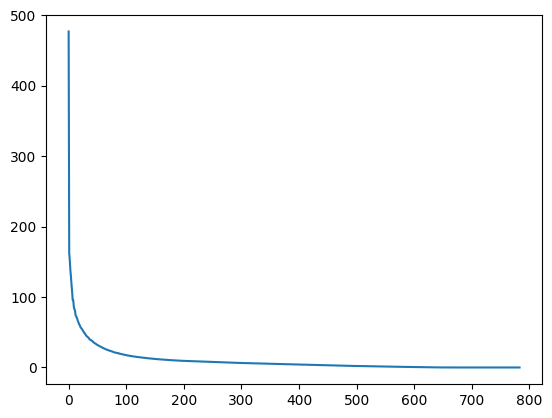

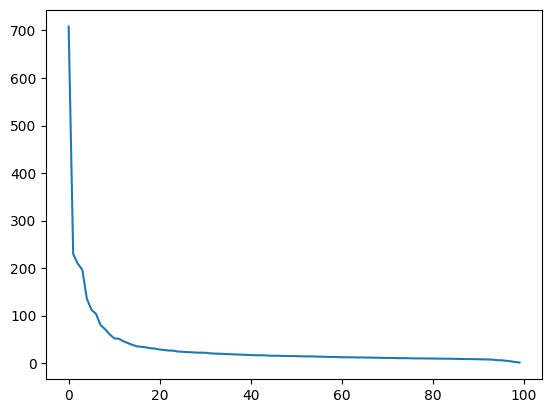

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(torch.diag(S1))

plt.figure()
plt.plot(torch.diag(S2).detach().numpy())

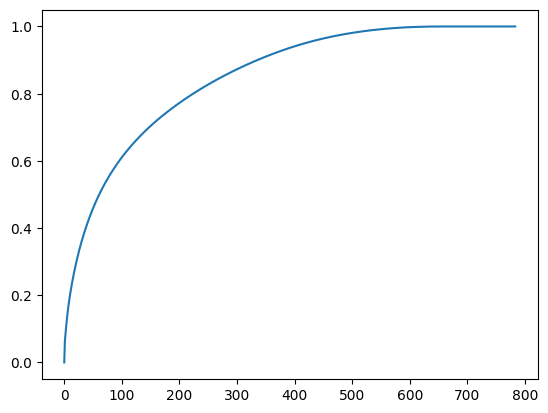

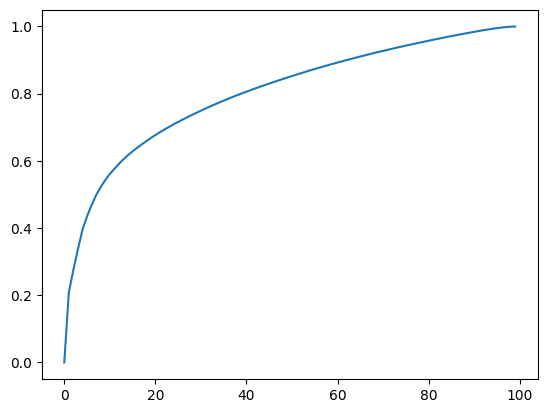

In [ ]:
diag_sum  = torch.sum(torch.diag(S1))

precentage_list1 = []
for i in range(S1.shape[0]):
    precentage_temp =  torch.sum(torch.diag(S1)[:i]) / diag_sum
    precentage_list1.append(precentage_temp)

# S2 = S2.detach().numpy()
diag_sum  = torch.sum(torch.diag(S2))

precentage_list2 = []
for i in range(S2.shape[0]):
    precentage_temp =  torch.sum(torch.diag(S2)[:i]) / diag_sum
    precentage_list2.append(precentage_temp.detach().numpy())

plt.figure()
plt.plot(precentage_list1)

plt.figure()
plt.plot(precentage_list2)



In [ ]:
import os
import sys
import datetime as dt
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

def calculate_svd(X):
    U, S_diag, V = torch.linalg.svd(X, full_matrices=False)
    S = torch.diag(S_diag)
    return U, S, V


def rmse(y_pred, y_true):
    mse = torch.nn.MSELoss()(y_pred, y_true)
    return torch.sqrt(mse)

def incre_svd(A, U_incre, S_incre, V_incre):

    num_sample  = A.shape[1]
    num_dim = A.shape[0]

    D = torch.matmul(torch.transpose(U_incre, 0, 1), A)

    E = A - torch.matmul(U_incre, D)

    I = torch.eye(num_sample).type(torch.float32)
    zero_matrix1 = torch.zeros(num_dim, num_dim).type(torch.float32)

    # QR for unitary
    E, R_E = torch.qr(E)

    # Form S_W
    top_row = torch.cat([S_incre, D], dim=1)
    bottom_row = torch.cat([zero_matrix1, R_E], dim=1)
    S_W = torch.cat([top_row, bottom_row], dim=0)

    U_S, S_S, V_S = calculate_svd(S_W)

    # update U, S, V
    U_incre = torch.matmul(torch.cat([U_incre, E], dim=1), U_S)

    S_incre = S_S

    zero_matrix2 = torch.zeros(num_dim, num_sample).type(torch.float32)
    zero_matrix3 = torch.zeros(num_sample, num_sample * (i+1)).type(torch.float32)
    top_row = torch.cat([V_incre, zero_matrix2], dim=1)
    bottom_row = torch.cat([zero_matrix3, I], dim=1)
    V_temp = torch.cat([top_row, bottom_row], dim=0)
    V_incre = torch.matmul(V_S, V_temp)

    print('U_incre, S_incre, V_incre after incremental updating')
    print(U_incre.shape, S_incre.shape, V_incre.shape)

    # truncation
    U_incre = U_incre[:, :num_dim]
    S_incre = S_incre[:num_dim, :num_dim]
    V_incre = V_incre[:num_dim]

    print('U_incre, S_incre, V_incre after truncation')
    print(U_incre.shape, S_incre.shape, V_incre.shape)

    return U_incre, S_incre, V_incre



In [ ]:
import os
import sys
import datetime as dt
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms


def calculate_svd(X):
    U, S_diag, V = torch.linalg.svd(X, full_matrices=False)
    S = torch.diag(S_diag)
    return U, S, V


def rmse(y_pred, y_true):
    mse = torch.nn.MSELoss()(y_pred, y_true)
    return torch.sqrt(mse)


num_sample = 1000
num_task = 10
# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
train_data = train_dataset.data
train_data = torch.reshape(train_data, (-1, 28*28))[:num_sample * num_task]
train_data = torch.transpose(train_data, 0, 1) / 255.0
print(train_data.shape)


# ---------------------------
# Incrementally Calculate SVD
# ---------------------------
train_data = train_data.type(torch.float32)

A_joint = train_data[:, :num_sample]
U_incre, S_incre, V_incre = calculate_svd(A_joint)
print('U_incre, S_incre, V_incre')
print(U_incre.shape, S_incre.shape, V_incre.shape)

I = torch.eye(num_sample).type(torch.float32)
zero_matrix1 = torch.zeros(784, 784).type(torch.float32)

U_norm_list = []
S_norm_list = []
V_norm_list = []

U_rmse_list = []
S_rmse_list = []
V_rmse_list = []

recon_rmse_list = []
recon_norm_list = []

for i in range(num_task-1):

    print('task = ', i)

    ss = np.arange(28*28)
    np.random.seed(i)
    np.random.shuffle(ss)

    A = train_data[ss, (i+1) * num_sample: (i+2)*num_sample]
    # print('A')
    # print(A.shape)

    U_incre, S_incre, V_incre = incre_svd(A, U_incre, S_incre, V_incre)

    # recon
    A_recon = torch.matmul(U_incre, torch.matmul(S_incre, V_incre))

    A_joint = torch.cat([A_joint, A], dim=1)

    U_joint, S_joint, V_joint = calculate_svd(A_joint)

    # F norm
    U_norm = torch.linalg.matrix_norm((U_incre - U_joint), ord='fro')
    S_norm = torch.linalg.matrix_norm((S_incre - S_joint), ord='fro')
    V_norm = torch.linalg.matrix_norm((V_incre[:784] - V_joint), ord='fro')

    U_norm_list.append(U_norm)
    S_norm_list.append(S_norm)
    V_norm_list.append(V_norm)

    U_rmse_list.append(rmse(U_incre, U_joint))
    S_rmse_list.append(rmse(S_incre, S_joint))
    V_rmse_list.append(rmse(V_incre[:784], V_joint))



    recon_rmse_list.append(rmse(A_recon, A_joint))
    recon_norm_list.append(torch.linalg.matrix_norm((A_recon - A_joint), ord='fro'))




Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.23MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.30MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.32MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([784, 10000])
U_incre, S_incre, V_incre
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 1000])
task =  0


<ipython-input-1-7e1057abfe0a>:32: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2422.)
  E, R_E = torch.qr(E)


U_incre, S_incre, V_incre after incremental updating
torch.Size([784, 1568]) torch.Size([1568, 1568]) torch.Size([1568, 2000])
U_incre, S_incre, V_incre after truncation
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 2000])
task =  1
U_incre, S_incre, V_incre after incremental updating
torch.Size([784, 1568]) torch.Size([1568, 1568]) torch.Size([1568, 3000])
U_incre, S_incre, V_incre after truncation
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 3000])
task =  2
U_incre, S_incre, V_incre after incremental updating
torch.Size([784, 1568]) torch.Size([1568, 1568]) torch.Size([1568, 4000])
U_incre, S_incre, V_incre after truncation
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 4000])
task =  3
U_incre, S_incre, V_incre after incremental updating
torch.Size([784, 1568]) torch.Size([1568, 1568]) torch.Size([1568, 5000])
U_incre, S_incre, V_incre after truncation
torch.Size([784, 784]) torch.Size([784, 784]) torch.Size([784, 5000])
task =  4


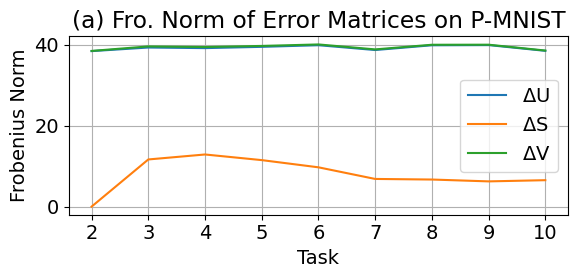

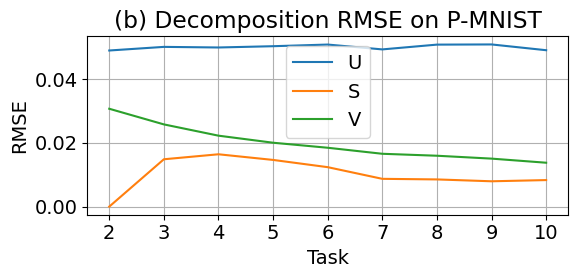

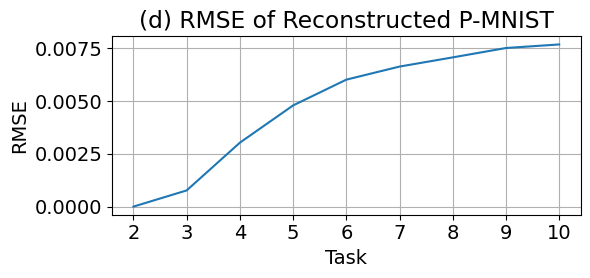

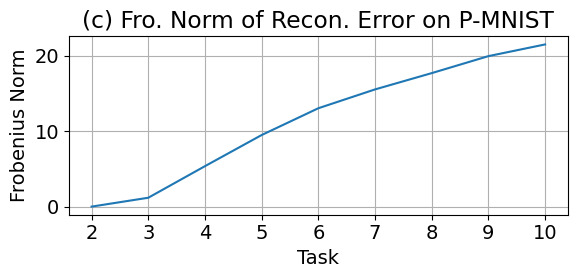

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', size=14)

plt.figure(figsize=(6, 3))
plt.title('(a) Fro. Norm of Error Matrices on P-MNIST')
plt.plot(U_norm_list, label='$\Delta$U')
plt.plot(S_norm_list, label = '$\Delta$S')
plt.plot(V_norm_list, label = '$\Delta$V')
plt.legend()
plt.xticks(list(range(9)), list(range(2,11)))
plt.xlabel('Task')
plt.ylabel('Frobenius Norm')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.title('(b) Decomposition RMSE on P-MNIST')
plt.plot(U_rmse_list, label='U')
plt.plot(S_rmse_list, label = 'S')
plt.plot(V_rmse_list, label = 'V')
plt.legend()
plt.xticks(list(range(9)), list(range(2,11)))
plt.xlabel('Task')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.title('(d) RMSE of Reconstructed P-MNIST')
plt.plot(recon_rmse_list)
plt.xticks(list(range(9)), list(range(2,11)))
plt.xlabel('Task')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.title('(c) Fro. Norm of Recon. Error on P-MNIST')
plt.plot(recon_norm_list)
plt.xticks(list(range(9)), list(range(2,11)))
plt.xlabel('Task')
plt.ylabel('Frobenius Norm')
plt.grid(True)
plt.tight_layout()
plt.show()

torch.Size([784, 10000])
torch.Size([784, 10000])


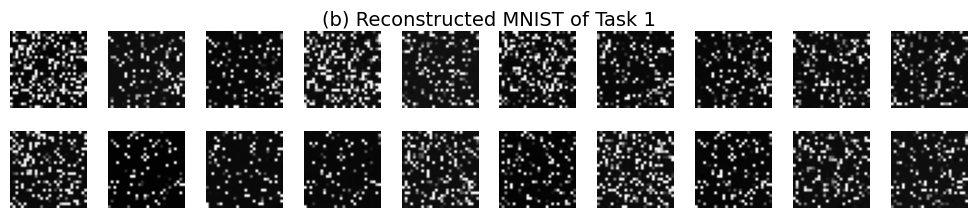

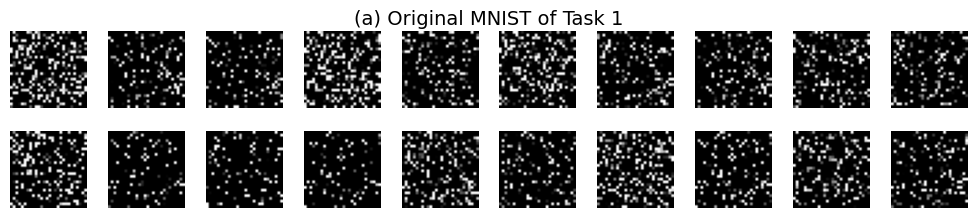

In [ ]:
print(A_recon.shape)
print(A_joint.shape)

fig, axs = plt.subplots(2, 10, figsize=(10, 3))
m=9000
for ii in range(2):
    for jj in range(10):
        axs[ii,jj].imshow(np.reshape(A_recon[:, m], (28,28)), cmap='gray')
        axs[ii,jj].axis('off')
        m+=1

fig.suptitle('(b) Reconstructed MNIST of Task 1', fontsize=14, y=0.8)
plt.tight_layout()

fig, axs = plt.subplots(2, 10, figsize=(10, 3))
m=9000
for ii in range(2):
    for jj in range(10):
        axs[ii,jj].imshow(np.reshape(A_joint[:, m], (28,28)), cmap='gray')
        axs[ii,jj].axis('off')
        m+=1

fig.suptitle('(a) Original MNIST of Task 1',  fontsize=14, y=0.8)
plt.tight_layout()


In [ ]:
import os
import sys
import datetime as dt
import numpy as np
import torch

def gram_schmidt_git(vv):
    def projection(u, v):
        return (v * u).sum() / (u * u).sum() * u

    nk = vv.size(0)
    uu = torch.zeros_like(vv, device=vv.device)
    uu[:, 0] = vv[:, 0].clone()
    for k in range(1, nk):
        vk = vv[k].clone()
        uk = 0
        for j in range(0, k):
            uj = uu[:, j].clone()
            uk = uk + projection(uj, vk)
        uu[:, k] = vk - uk
    for k in range(nk):
        uk = uu[:, k].clone()
        uu[:, k] = uk / uk.norm()
    return uu


A = np.random.rand(5,5)
print(A)

A = torch.from_numpy(A).type(torch.float32)
print(A)

B = gram_schmidt_git(A)
print(B)

[[0.82113417 0.81546337 0.57073854 0.51578999 0.34825864]
 [0.27047149 0.56897038 0.94478452 0.00973588 0.78370444]
 [0.75617312 0.27116824 0.73486393 0.85568895 0.7466302 ]
 [0.44599964 0.62594009 0.12996081 0.35923976 0.45481154]
 [0.89096744 0.30725953 0.14357338 0.57976461 0.20118754]]
tensor([[0.8211, 0.8155, 0.5707, 0.5158, 0.3483],
        [0.2705, 0.5690, 0.9448, 0.0097, 0.7837],
        [0.7562, 0.2712, 0.7349, 0.8557, 0.7466],
        [0.4460, 0.6259, 0.1300, 0.3592, 0.4548],
        [0.8910, 0.3073, 0.1436, 0.5798, 0.2012]])
tensor([[ 0.5400, -0.5114, -0.3919,  0.1960,  0.5049],
        [ 0.1779,  0.5014,  0.2434,  0.7855,  0.2016],
        [ 0.4973,  0.5002,  0.1955, -0.5830,  0.3527],
        [ 0.2933, -0.4692,  0.8163,  0.0222, -0.1640],
        [ 0.5860,  0.1294, -0.2873,  0.0646, -0.7438]])


In [ ]:
print(torch.matmul(B.t(), B))

tensor([[ 1.0000e+00,  6.0018e-08,  6.9169e-08,  1.3315e-08,  1.9976e-07],
        [ 6.0018e-08,  1.0000e+00, -1.4336e-07, -3.7883e-08,  1.2534e-07],
        [ 6.9169e-08, -1.4336e-07,  1.0000e+00, -5.5667e-08, -1.7799e-07],
        [ 1.3315e-08, -3.7883e-08, -5.5667e-08,  1.0000e+00,  1.0048e-07],
        [ 1.9976e-07,  1.2534e-07, -1.7799e-07,  1.0048e-07,  1.0000e+00]])
